In [1]:
import os
import pymysql
import pandas as pd
import numpy as np
from dotenv import load_dotenv, find_dotenv

In [2]:
from customerclustering.db_connection import Db
from customerclustering.get_training_data import *
from customerclustering.baseline import *

In [3]:
# df0=GetTrainingData(conn=Db.db_conn(),rows=20).get_training_data()

# access to the data
# conn = pymysql.connect(
#     host=os.getenv('HOST'),
#     port=int(3306),
#     user=os.getenv('USER_DB'),
#     passwd=os.getenv('PASSWORD_DB'),
#     db=os.getenv('DB'),
#     charset='utf8mb4')

# rows=20000
# df=GetTrainingData(conn,rows).get_training_data()
# df_copy=df
# df.head()

In [4]:
training_data = pd.read_csv("../raw_data/training_data_1.csv")

# Categorical Features

In [5]:
import io
buffer = io.StringIO()
training_data.info(buf=buffer)
lines = buffer.getvalue().splitlines()
column_df = (pd.DataFrame([x.split() for x in lines[6:-2]], columns=lines[3].split())
       .drop('Count',axis=1)
       .rename(columns={'Non-Null':'Non-Null Count'}))
column_df.head()

,#,Column,Non-Null Count,Dtype
0,1,Product,7482,object
1,2,Status,7482,object
2,3,userID,7482,object
3,4,stripeCustID,7482,object
4,5,num_subs,7482,int64


In [6]:
#categorical data only

cat_columns = column_df[column_df['Dtype']=='object'].reset_index().Column
non_cat_columns = column_df[column_df['Dtype']!='object'].reset_index().Column

cat_columns_df = training_data[cat_columns].drop(columns =['userID','stripeCustID','pProfileID'])

# 'startDate','endDate','createDate'

unique_value_list = []
for x in range(0, len(cat_columns_df.columns)):
    y = cat_columns_df[cat_columns_df.columns[x]].nunique()
    unique_value_list.append([cat_columns_df.columns[x], y])
    
unique_value_df = pd.DataFrame(unique_value_list, columns = ['column_name','unique_count'])
unique_value_df.sort_values(by ='unique_count')

,column_name,unique_count
13,plan_type,3
9,access,4
1,Status,5
8,autonomy,6
3,located,7
10,country,7
0,Product,8
7,complex,8
11,activityType,12
12,secondFavActivityType,13


In [7]:
#Ordinal Encoding
#autonomy;
#plan_type;
#access
#Status: clean to 0 and 1, active and inactive;
#complex: 0-3; further cleaning required to get the consistent wording;


In [8]:
#OneHotEncoder
#located: clean and condense to rural and city only;
#favActivityType: reduced to 5 and other;
#2ndFavActivityType: reduced to 5 and other;


In [9]:
#feature to remove
#country: 6123 out of 6129 are from AUS;
#Product: unsure 5,772 Ausmed subscriptons vs 351 loyalty subscription; futher cleaning needed;


## feature reviewing

In [10]:
training_data['autonomy'].value_counts()

moderate                                      4209
high                                          1788
minimal                                        728
a moderate amount of professional autonomy      11
a high level of professional autonomy            4
a minimal professional autonomy                  1
Name: autonomy, dtype: int64

In [11]:
training_data['plan_type'].value_counts()

quarterly    5240
monthly      1442
annually      800
Name: plan_type, dtype: int64

In [12]:
training_data['access'].value_counts()

always       3996
usually      2117
sometimes     595
never          33
Name: access, dtype: int64

In [13]:
training_data['Status'].value_counts()

active                4004
canceled              3310
past_due               141
incomplete_expired      24
trialing                 3
Name: Status, dtype: int64

In [14]:
training_data['located'].value_counts()

metropolitan centre          2832
large rural centre           1485
capital city                 1232
small rural centre            925
remote area                   261
other metropolitan centre       5
other rural area                1
Name: located, dtype: int64

In [15]:
training_data['country'].value_counts()

AUS    7461
NZL      13
GBR       4
ARE       1
USA       1
ZAF       1
MYS       1
Name: country, dtype: int64

In [16]:
training_data['Product'].value_counts()

Ausmed Subscription            6160
Ausmed Subscription Monthly     663
Loyalty Subscription            483
Ausmed Loyalty Monthly          154
Ausmed NZ Subscription           11
Ausmed US Subscription            7
Ausmed UK Subscription            3
Ausmed Loyalty Annually           1
Name: Product, dtype: int64

In [17]:
training_data['complex'].value_counts()

generally complex         3975
very complex              1467
high complexity            811
low complexity             459
be generally complex        12
be very complex             10
have a high complexity       4
have high complexity         3
Name: complex, dtype: int64

In [18]:
training_data['activityType'].value_counts()

e-Learning           4254
Textbook             1640
Competency            587
In-Service            474
Conference            183
Other                 156
Teaching               54
Mentoring              51
Meeting                38
Postgraduate           26
Procedure              16
Peer Consultation       3
Name: activityType, dtype: int64

In [19]:
training_data['secondFavActivityType'].value_counts()

e-Learning           3388
Textbook             1837
Competency            750
In-Service            677
Other                 280
Conference            273
Teaching               89
Meeting                63
Mentoring              59
Procedure              34
Postgraduate           27
Peer Consultation       3
Research                2
Name: secondFavActivityType, dtype: int64

In [20]:
import joblib

baseline = joblib.load("../model.joblib")

training_data_df = pd.read_csv("../raw_data/training_data.csv", index_col=[0])

c = baseline.predict(training_data_df)

In [21]:
training_data_df_labels = training_data_df.copy()
training_data_df_labels['col_labels'] = c

In [22]:
individual_user = baseline.predict(training_data_df.iloc[:1, :])

In [23]:
individual_user

array([7], dtype=int32)

In [24]:
# df_labels.to_csv('../raw_data/df_with_labels.csv')

In [25]:
cluster_df = pd.read_csv("../raw_data/df_with_labels.csv",index_col=[0])
cluster_df.head()

,Product,Status,userID,stripeCustID,num_subs,account_age,pProfileID,typeOfPractice,located,specialities,...,RatioOfCompletion_min,event_cpd_day_diff,doc_in_activation,activated,plan_type,subscribe_days,GoalsPerYear,ratioOfAchivedGoals,metaGoalTitle,col_labels
0,Ausmed Subscription,incomplete_expired,6037d38d-d098-4f68-be8c-49b7131b8116,cus_CVloz8uJiXpqfF,10,1613.0,41b3e81d-ccdd-40c8-b268-874344b0a1bf,hospital,remote area,"Rehabilitation,Aged care ,Medical",...,0.000000,117.197044,10,1,quarterly,1538,5.0,0.4,"To gain confidence ,skills and knowledge as a ...",7
1,Ausmed Subscription,canceled,62d1fe96-34f6-4992-9f15-b240f07770d8,cus_EoCO9ITZcMHmkA,9,1233.0,71a06b47-4762-49d2-b5fd-161c7ce6e1cd,hospital,large rural centre,Addiction and Substance Abuse,...,0.000000,164.064103,2,1,quarterly,0,1.5,0.0,Do my best Gehenna d f r dwa wa daw daw,9
2,Ausmed Subscription,canceled,6e6b0e01-4a29-4724-a781-5d6a0d72a213,cus_BVqWWYIZ4tLhQr,6,2122.0,0cccdf89-bae9-4d06-8a40-81a6c7b3b7ce,GP Surgery,metropolitan centre,"Immunisation,Chronic Illness",...,0.071138,149.362205,4,1,monthly,193,2.0,0.0,Covid vaccination and wound management. \nMy r...,10
3,Ausmed Subscription,active,33d2881f-8bc6-4b98-bafe-bfd20b141ee2,cus_AVUDPqhuPS9HRy,5,1945.0,72593341-edad-404e-9a92-bf7f576e5207,hospital,metropolitan centre,aged care; wound care and the continuity of he...,...,0.013096,76.311787,2,1,quarterly,315,1.0,0.0,By the end of 2021 I would like to expand my k...,6
4,Ausmed Subscription,incomplete_expired,5f048ee3-4ea0-41e1-b859-c1cd9c95d80b,cus_F71ikWaGTyumEe,5,1183.0,752db353-5793-4636-acd7-fe3205291c91,Unemployed.,small rural centre,NaN,...,0.000000,8.618321,4,1,quarterly,73,2.0,0.0,"Study, learn and retain knowledge. Do online s...",5


In [26]:
cluster_df['col_labels'].value_counts()

9     1700
6     1353
5      987
2      688
10     666
4      368
8      172
7       86
3       86
0       20
1        3
Name: col_labels, dtype: int64

In [27]:
cluster_df[cluster_df['col_labels']==1]

,Product,Status,userID,stripeCustID,num_subs,account_age,pProfileID,typeOfPractice,located,specialities,...,RatioOfCompletion_min,event_cpd_day_diff,doc_in_activation,activated,plan_type,subscribe_days,GoalsPerYear,ratioOfAchivedGoals,metaGoalTitle,col_labels
2070,Ausmed Subscription,canceled,43efb25e-4c95-4ab8-957a-75ee802157c3,cus_F0AvpPOlOFjQS0,1,1201.0,597b1305-113a-4c0e-9954-f26f949e4131,private practice,capital city,theatre,...,0.0,82.687500,1,0,quarterly,82,1.000000,0.000,..,1
2634,Loyalty Subscription,active,5c51d36e-c616-4b40-80da-0536102c9b15,cus_CF3csnbEaeegKE,1,1658.0,9960a41b-009e-48b2-b217-fabafe106705,general medical practice,capital city,"Adolescent Health,Aged Care,Midwi,Midwifery,In...",...,0.0,149.750000,6,1,annually,1656,2.666667,0.375,To improve my understanding of Influenza Preve...,1
4566,Loyalty Subscription,active,b540968d-a3a2-4712-bb7b-3348926cb3b2,cus_DfrcWtcr6VuSwC,1,2016.0,93b85cba-fec1-4fb6-9897-bf6f4d224f17,residential aged care facility,large rural centre,"Aged Care, Home Care,Accreditation,Ageing",...,0.0,279.705882,1,0,monthly,1419,3.000000,0.500,To Complete Certificate IV in WH&S Undertake ...,1


In [28]:
import seaborn as sns

In [29]:
cluster_df.columns

Index(['Product', 'Status', 'userID', 'stripeCustID', 'num_subs',
       'account_age', 'pProfileID', 'typeOfPractice', 'located',
       'specialities', 'population', 'focus', 'complex', 'autonomy', 'access',
       'startDate', 'endDate', 'createDate', 'country', 'favActivityType',
       '2ndFavActivityType', 'minPerYear', 'percentageOfLearningFromAusmed',
       'numQueued', 'numCompletedFromQueue', 'minQueued', 'minCompleted',
       'RatioOfCompletion_num', 'RatioOfCompletion_min', 'event_cpd_day_diff',
       'doc_in_activation', 'activated', 'plan_type', 'subscribe_days',
       'GoalsPerYear', 'ratioOfAchivedGoals', 'metaGoalTitle', 'col_labels'],
      dtype='object')

In [30]:
from IPython.display import Markdown
import matplotlib.pyplot as plt

cluster_df_new = cluster_df.drop(columns = ['Product', 'stripeCustID', 'userID','pProfileID',\
                                            'focus', 'typeOfPractice', 'specialities', 'population',\
                                            'country', 'metaGoalTitle'])

# hue = 'col_labels'
# vars_per_line = 5
# all_vars = list(cluster_df_new.columns.symmetric_difference([hue]))
           
# for var in all_vars:
#     rest_vars = list(all_vars)
#     rest_vars.remove(var)
#     display(Markdown(f"## {var}"))
#     while rest_vars:
#         line_vars = rest_vars[:vars_per_line]
#         del rest_vars[:vars_per_line]
#         line_var_names = ", ".join(line_vars)
#         display(Markdown(f"### {var} vs {line_var_names}"))
#         sns.pairplot(cluster_df_new, x_vars=line_vars, y_vars=[var], hue=hue, palette='bright', \
#                      height = 2, aspect = 1 )
#         plt.show()
#         plt.close()      

# features and clusters

## separate num and cat features

In [31]:
from IPython.display import Markdown
import matplotlib.pyplot as plt

cluster_df_new = cluster_df.drop(columns = ['Product', 'stripeCustID', 'userID','pProfileID',\
                                            'focus', 'typeOfPractice', 'specialities', 'population',\
                                            'country', 'metaGoalTitle'])
import io
buffer = io.StringIO()
cluster_df_new.info(buf=buffer)
lines = buffer.getvalue().splitlines()
column_df_new = (pd.DataFrame([x.split() for x in lines[6:-2]], columns=lines[3].split())
       .drop('Count',axis=1)
       .rename(columns={'Non-Null':'Non-Null Count'}))
column_df_new.head()

,#,Column,Non-Null Count,Dtype
0,1,num_subs,6129,int64
1,2,account_age,6129,float64
2,3,located,6129,object
3,4,complex,6129,object
4,5,autonomy,6129,object


In [32]:
cat_col_list = list(column_df_new[column_df_new['Dtype'] == 'object'].Column)
cat_col_list.append('col_labels')
non_cat_col_list= list(column_df_new[column_df_new['Dtype'] != 'object'].Column)

cat_col_list
# non_cat_col_list

['located',
 'complex',
 'autonomy',
 'access',
 'startDate',
 'endDate',
 'createDate',
 'favActivityType',
 '2ndFavActivityType',
 'plan_type',
 'col_labels']

## num feature plotting

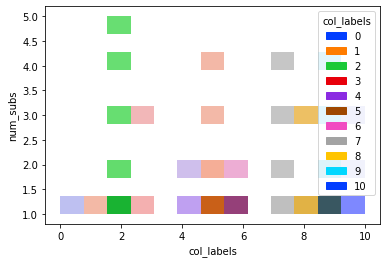

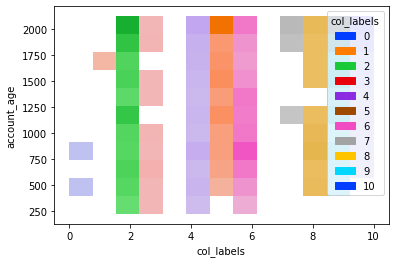

In [ ]:
x = 'col_labels'
all_vars = non_cat_col_list
           
for y in non_cat_col_list:
    sns.histplot(x = x, y =y, hue = x,data = cluster_df_new.sample(1000), palette='bright')
    plt.show()
    plt.close() 


## cat columns plotting

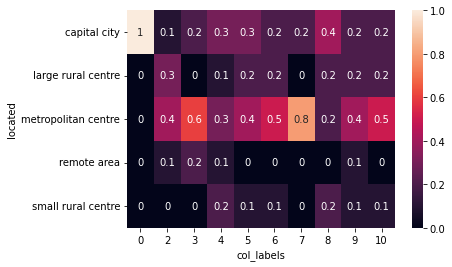

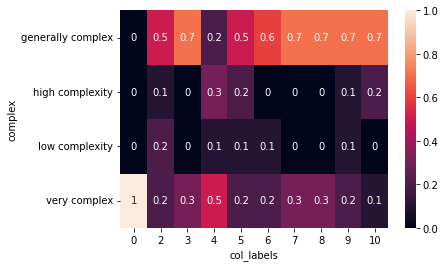

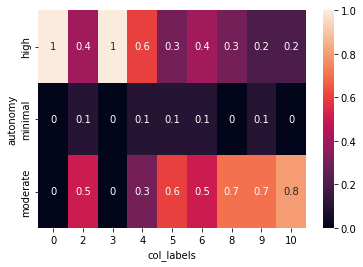

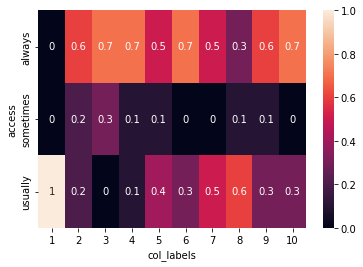

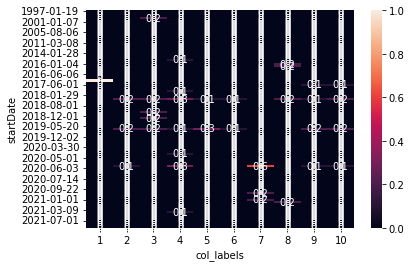

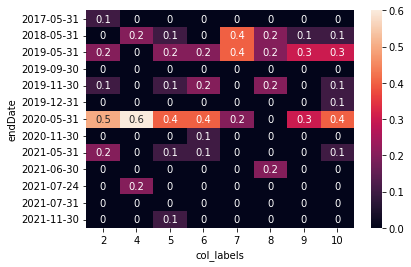

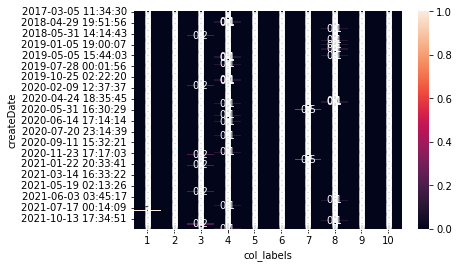

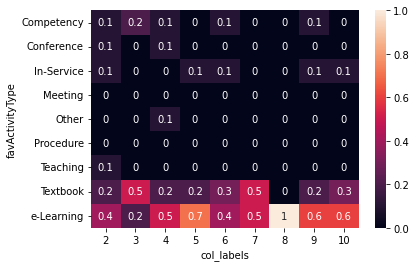

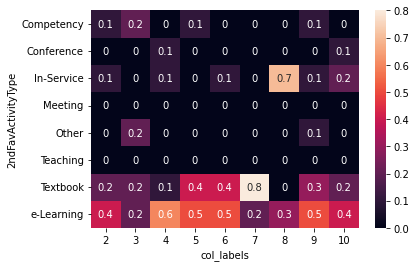

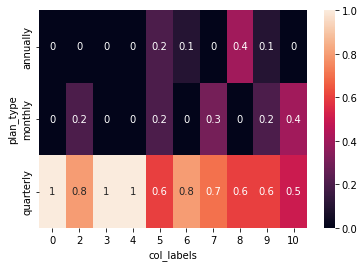

ValueError: Grouper for 'col_labels' not 1-dimensional

<Figure size 432x288 with 0 Axes>

In [39]:
cluster_df_new['count'] = 1

for feature in cat_col_list:
    heat_df = pd.pivot_table(cluster_df_new.sample(200), values='count', index=[feature],
                    columns=['col_labels'], aggfunc=np.sum, fill_value=0)

    for col in heat_df.columns:
        total = heat_df[col].sum()
        heat_df[col] = round(heat_df[col]/total,1)

    sns.heatmap(heat_df, annot = True)
    plt.show()
    plt.savefig(f"../png_folder/{feature}.png")